## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset
import pickle
from sklearn.model_selection import train_test_split

/opt/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

In [2]:
data = pd.read_csv("data/cleaned_static_features.csv",index_col=0)
with open("data/groups.pkl", 'rb') as file:
    groups = pickle.load(file)

In [3]:
disorders = ["Voice Disorders", "Neurological and Neurodegenerative Disorders", "Mood and Psychiatric Disorders","Respiratory Disorders"]
y_voice = data["Voice Disorders"].copy().to_numpy()
X = data.copy().drop(columns=["participant_id", "session_id","task_name"]+disorders).to_numpy()

## Preprocessing

### Average over sessions within subject

In [4]:
n_subj = groups[-1]+1
X_ave = np.zeros((n_subj, X.shape[1]))
y_voice_ave = np.zeros(n_subj)
for g in np.arange(n_subj):
    curr_X = X[np.where(groups==g)].mean(axis=0)
    X_ave[g] = curr_X
    y_voice_ave[g] = y_voice[np.where(groups==g)].mean()
print(X_ave.shape)

(442, 97)


### Normalization

In [5]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_proc = ss.fit_transform(X_ave)

## Train XGBoost with hyperparameter tuning

In [7]:
# Run GridSearchCV only for Voice disorder and visualize all combinations' train vs validation performance
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def grid_search(param_grid:dict, y_curr, label:str, n_splits:int=10):
    # Split off a held-out test set (never used for CV)
    X_tr, X_te, y_tr, y_te = train_test_split(X_ave, y_curr, test_size=0.15, random_state=42, stratify=y_curr)

    base_gbc = GradientBoostingClassifier(random_state=42)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    gscv = GridSearchCV(base_gbc, param_grid, scoring='f1_weighted', cv=skf, n_jobs=-1, refit=True, return_train_score=True)
    gscv.fit(X_tr, y_tr)

    # Convert cv_results_ into a DataFrame for easier analysis
    cv_res = pd.DataFrame(gscv.cv_results_)
    # keep only relevant cols
    cols = ['params','mean_train_score','std_train_score','mean_test_score','std_test_score','rank_test_score']
    summary_grid = cv_res[cols].sort_values('rank_test_score').reset_index(drop=True)

    print('Top 5 hyperparameter combinations (by validation rank):')
    for i, row in summary_grid.head(5).iterrows():
        print(f"Rank {int(row['rank_test_score'])}: val={row['mean_test_score']:.4f}, train={row['mean_train_score']:.4f}, params={row['params']}")

    # Scatter plot: train vs validation for every combo
    fig, ax = plt.subplots(figsize=(8,6))
    x = summary_grid['mean_train_score']
    y = summary_grid['mean_test_score']
    sc = ax.scatter(x, y, c=summary_grid['rank_test_score'], cmap='viridis', s=60, edgecolor='k')
    ax.plot([0,1],[0,1],'--',color='gray',linewidth=1)  # reference line where train==val
    ax.set_xlabel('Mean Train F1 (CV)')
    ax.set_ylabel('Mean Validation F1 (CV)')
    ax.set_title('Train vs Validation F1 for all hyperparameter combinations (Voice)')
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Rank (lower is better)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot the overfitting gap (train - val) sorted by rank
    summary_grid['train_minus_val'] = summary_grid['mean_train_score'] - summary_grid['mean_test_score']
    fig, ax = plt.subplots(figsize=(10,4))
    ax.bar(range(len(summary_grid)), summary_grid['train_minus_val'], color='C1')
    ax.set_xlabel('Hyperparameter combination (sorted by validation rank)')
    ax.set_ylabel('Train F1 - Validation F1')
    ax.set_title('Overfitting gap per hyperparameter combination (Voice)')
    plt.tight_layout()
    plt.show()

    # Evaluate best estimator on held-out test set and show report
    best = gscv.best_estimator_
    y_test_pred = best.predict(X_te)
    test_f1 = f1_score(y_te, y_test_pred, average='weighted')
    print('Classification report (test):')
    print(classification_report(y_te, y_test_pred))
    print('Confusion matrix (test):')
    print(confusion_matrix(y_te, y_test_pred))

    # Save results to a dict for later use
    grid_search_results = {'cv_results_df': summary_grid, 'best_params': gscv.best_params_, 'best_score_cv': gscv.best_score_, 'test_f1': test_f1, 'best_estimator': best}
    return grid_search_results


Top 5 hyperparameter combinations (by validation rank):
Rank 1: val=0.8026, train=1.0000, params={'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Rank 2: val=0.7916, train=1.0000, params={'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
Rank 2: val=0.7916, train=1.0000, params={'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
Rank 2: val=0.7916, train=1.0000, params={'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
Rank 5: val=0.7835, train=0.9887, params={'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}


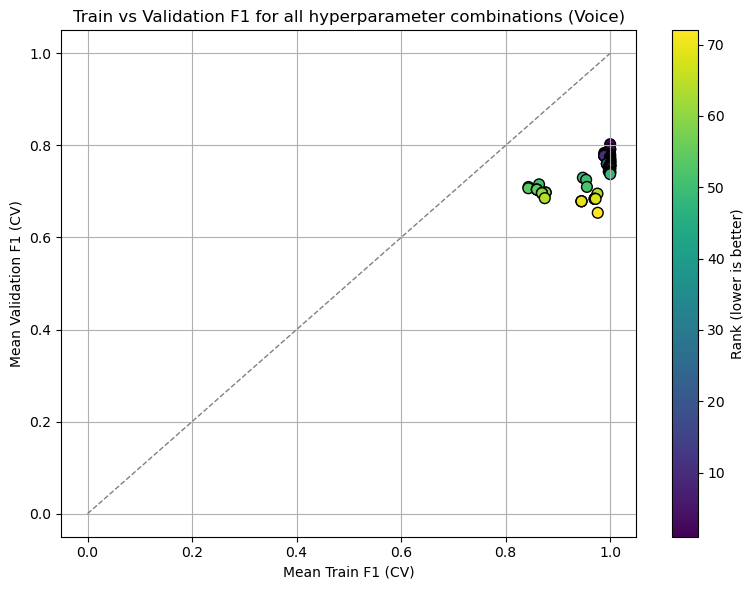

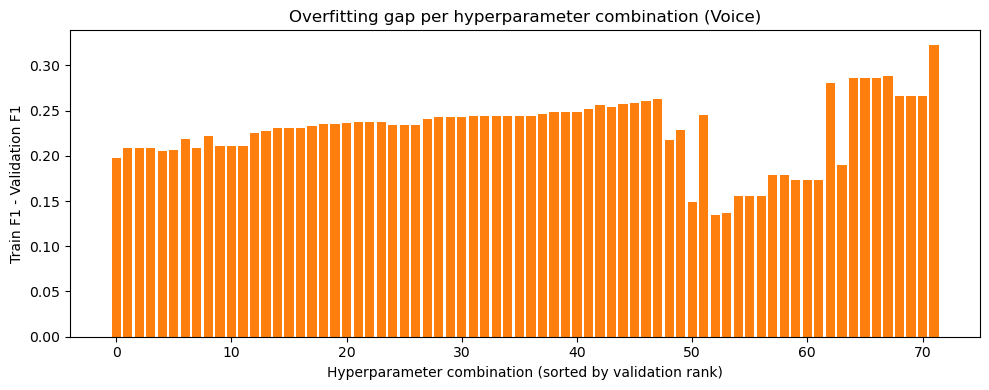

Classification report (test):
              precision    recall  f1-score   support

         0.0       0.65      0.75      0.70        32
         1.0       0.73      0.63      0.68        35

    accuracy                           0.69        67
   macro avg       0.69      0.69      0.69        67
weighted avg       0.69      0.69      0.69        67

Confusion matrix (test):
[[24  8]
 [13 22]]


In [10]:
# Slightly smaller grid for Voice-only tuning to keep runtime reasonable while exploring combinations
param_grid = {
    'n_estimators': [5, 50, 100],
    "max_depth": [3, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5],
    'max_features': ['sqrt', int(X_ave.shape[1]*0.5)],
}

grid_search_voice = grid_search(param_grid, y_voice_ave, "Voice")

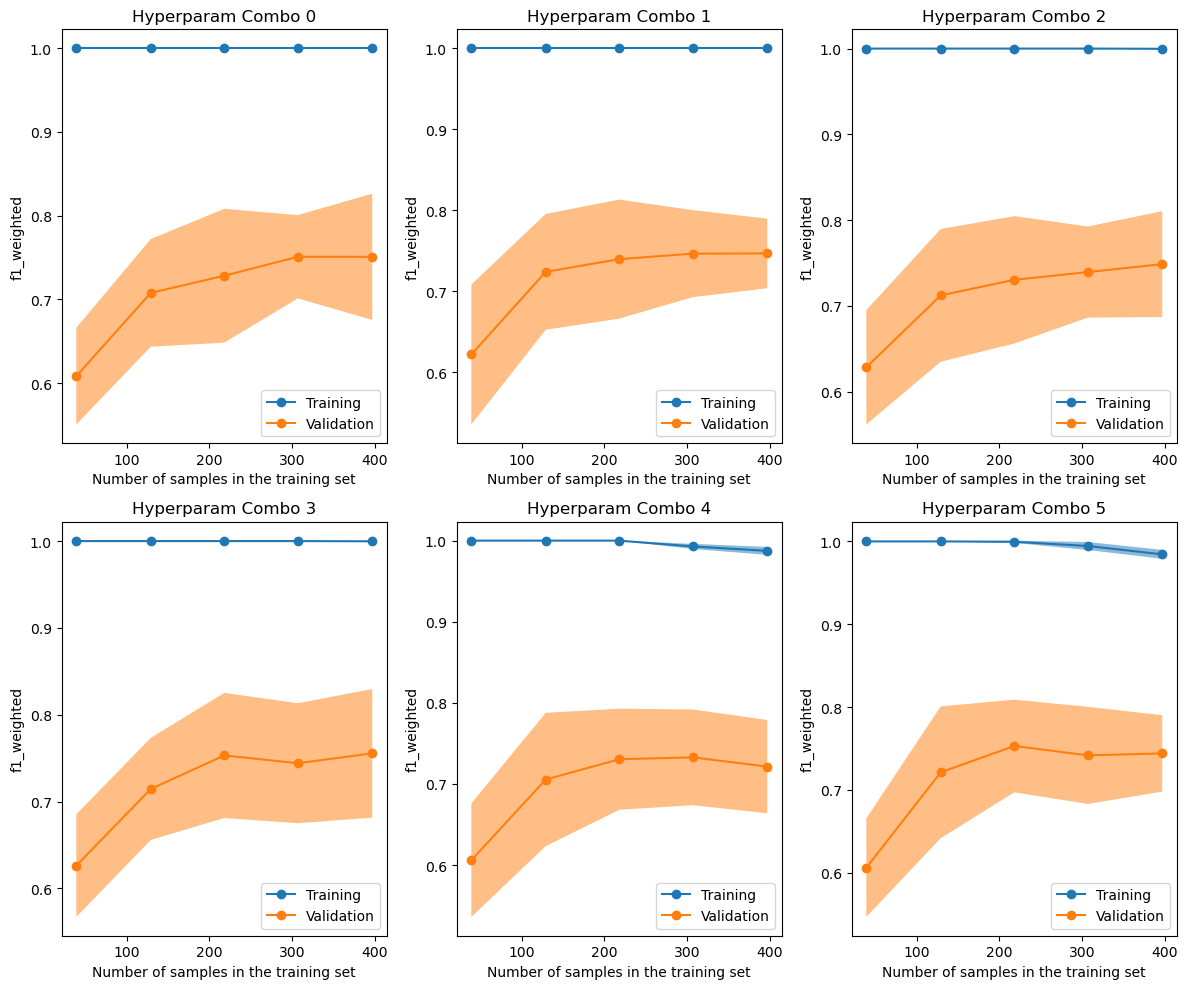

In [11]:
top_params = grid_search_voice["cv_results_df"].sort_values("rank_test_score",ascending=True)[:6]['params'].tolist()

from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))

common_params = {
    "X": X_ave,
    "y": y_voice_ave,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f1_weighted",
}

for i,(ax,params) in enumerate(zip(axes.flatten(), top_params)):
    estimator = GradientBoostingClassifier(**params)
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
    
    handles, label = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ["Training", "Validation"])
    ax.set_title(f"Hyperparam Combo {i}") 

plt.tight_layout()
plt.show()

#### Almost all of the models are heavily overfitting, and based on the learning curves it looks like the model is too expressive and/or we don't have enough data. This makes sense given that we saw overfitting with the RandomForest model, which is less expressive than a gradient boosted classifier.